In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'DOGE'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,0.145419,0.156989,0.145400,0.155526,0.155526,1767635344
2024-05-16,0.155529,0.159025,0.149070,0.149637,0.149637,1374063837
2024-05-17,0.149637,0.156364,0.149517,0.155563,0.155563,1112782871
2024-05-18,0.155563,0.156872,0.151657,0.153077,0.153077,771261615
2024-05-19,0.153077,0.155964,0.147957,0.149107,0.149107,786457296


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.149107

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.993821,0.993677,0.992448,0.992448,0.549308
High,0.993821,1.000000,0.986423,0.995079,0.995079,0.614785
Low,0.993677,0.986423,1.000000,0.994539,0.994539,0.513546
Close,0.992448,0.995079,0.994539,1.000000,1.000000,0.582634
Adj Close,0.992448,0.995079,0.994539,1.000000,1.000000,0.582634
Volume,0.549308,0.614785,0.513546,0.582634,0.582634,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.001415,6259550
2017-11-10,0.001163,4246520
2017-11-11,0.001201,2231080
2017-11-12,0.001038,3288960
2017-11-13,0.001211,2481270
...,...,...
2024-05-15,0.155526,1767635344
2024-05-16,0.149637,1374063837
2024-05-17,0.155563,1112782871


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.008486,51201500,0.007735,0.004723,0.003451
2017-12-29,0.009391,62474900,0.008107,0.004966,0.003610
2017-12-30,0.007860,56175300,0.008227,0.005159,0.003744
2017-12-31,0.008972,62256400,0.008382,0.005386,0.003900
2018-01-01,0.008909,50616900,0.008667,0.005612,0.004057


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-15,0.155526,1767635344,0.147977,0.149525,0.165442
2024-05-16,0.149637,1374063837,0.147280,0.149313,0.164628
2024-05-17,0.155563,1112782871,0.147818,0.149578,0.163338
2024-05-18,0.153077,771261615,0.148796,0.149599,0.162130
2024-05-19,0.149107,786457296,0.148495,0.149360,0.161123


<Axes: xlabel='Date'>

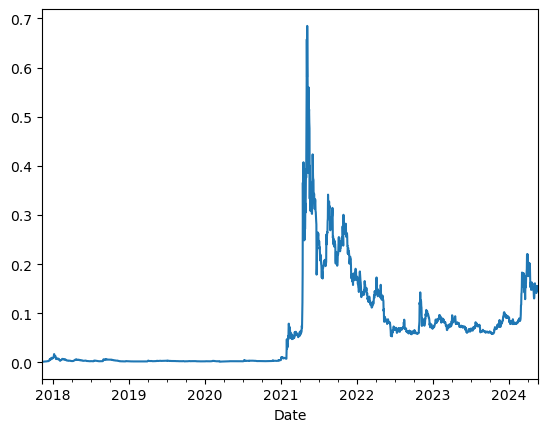

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.001415,6259550
1,2017-11-10,0.001163,4246520
2,2017-11-11,0.001201,2231080
3,2017-11-12,0.001038,3288960
4,2017-11-13,0.001211,2481270
...,...,...,...
2379,2024-05-15,0.155526,1767635344
2380,2024-05-16,0.149637,1374063837
2381,2024-05-17,0.155563,1112782871
2382,2024-05-18,0.153077,771261615


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:49 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2469,2024-08-13
2470,2024-08-14
2471,2024-08-15
2472,2024-08-16
2473,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2444,2024-07-19,0.123282,0.060034,0.151796,0.116703,0.128729,-0.016999,-0.016999,-0.016999,0.000485,0.000485,0.000485,-0.017485,-0.017485,-0.017485,0.0,0.0,0.0,0.106283
2445,2024-07-20,0.123389,0.064332,0.149380,0.116703,0.129015,-0.017088,-0.017088,-0.017088,0.000337,0.000337,0.000337,-0.017425,-0.017425,-0.017425,0.0,0.0,0.0,0.106301
2446,2024-07-21,0.123496,0.063145,0.148580,0.116611,0.129329,-0.016897,-0.016897,-0.016897,0.000429,0.000429,0.000429,-0.017326,-0.017326,-0.017326,0.0,0.0,0.0,0.106599
2447,2024-07-22,0.123603,0.064693,0.148160,0.116406,0.129729,-0.017231,-0.017231,-0.017231,-0.000044,-0.000044,-0.000044,-0.017186,-0.017186,-0.017186,0.0,0.0,0.0,0.106372
2448,2024-07-23,0.123709,0.062864,0.149142,0.116419,0.130053,-0.017452,-0.017452,-0.017452,-0.000451,-0.000451,-0.000451,-0.017001,-0.017001,-0.017001,0.0,0.0,0.0,0.106258
2449,2024-07-24,0.123816,0.062026,0.150017,0.116299,0.130346,-0.017200,-0.017200,-0.017200,-0.000434,-0.000434,-0.000434,-0.016766,-0.016766,-0.016766,0.0,0.0,0.0,0.106616
2450,2024-07-25,0.123923,0.063772,0.150518,0.116169,0.130947,-0.016799,-0.016799,-0.016799,-0.000322,-0.000322,-0.000322,-0.016477,-0.016477,-0.016477,0.0,0.0,0.0,0.107124
2451,2024-07-26,0.124030,0.068677,0.152909,0.116067,0.131388,-0.015646,-0.015646,-0.015646,0.000485,0.000485,0.000485,-0.016131,-0.016131,-0.016131,0.0,0.0,0.0,0.108384
2452,2024-07-27,0.124137,0.062466,0.155646,0.115997,0.131782,-0.015388,-0.015388,-0.015388,0.000337,0.000337,0.000337,-0.015724,-0.015724,-0.015724,0.0,0.0,0.0,0.108749
2453,2024-07-28,0.124244,0.063894,0.151990,0.115746,0.132066,-0.014824,-0.014824,-0.014824,0.000429,0.000429,0.000429,-0.015253,-0.015253,-0.015253,0.0,0.0,0.0,0.109420


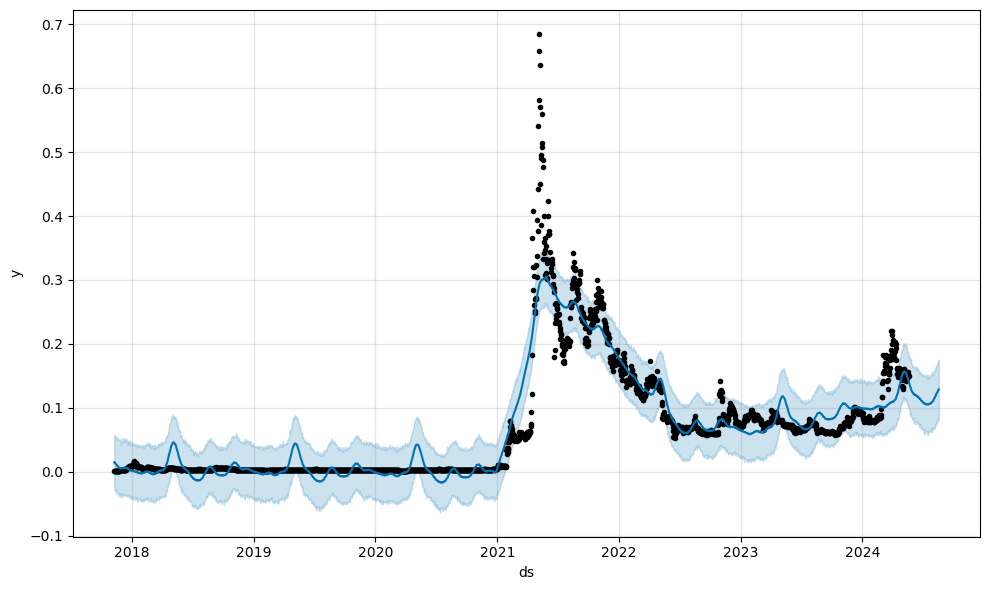

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,0.138878,0.097334,0.181565
2024-05-21,0.136650,0.096388,0.178657
2024-05-22,0.134895,0.089301,0.177902
2024-05-23,0.133302,0.087517,0.173492
2024-05-24,0.132487,0.091882,0.177049
...,...,...,...
2024-08-13,0.124596,0.077626,0.169182
2024-08-14,0.125641,0.082974,0.170729
2024-08-15,0.126715,0.081124,0.172224


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

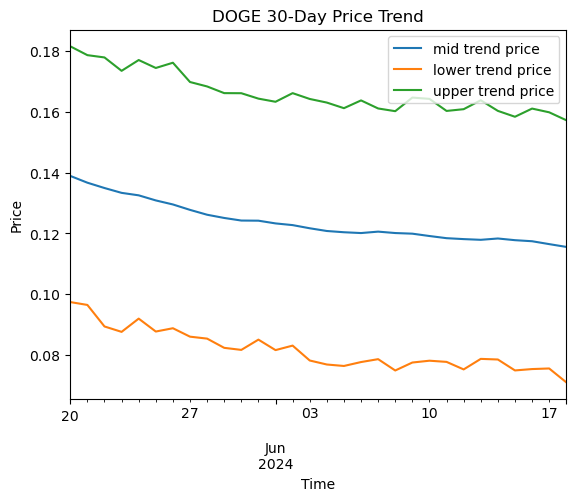

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

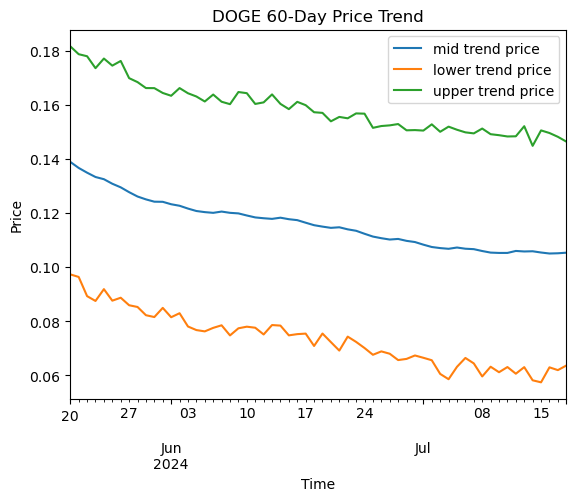

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

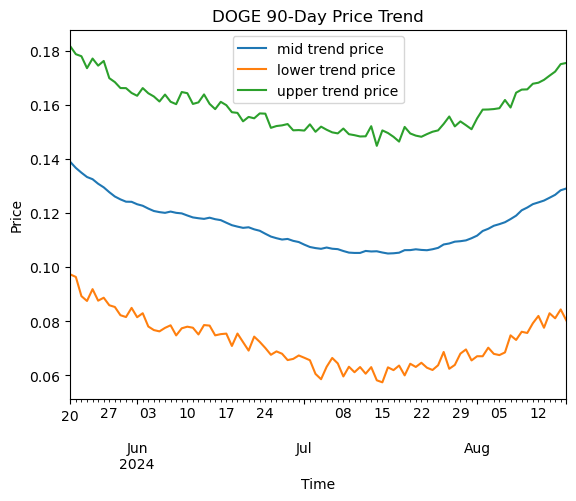

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.149107

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.13887782124001066

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.14399241062000534

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.1391064980622846

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.11548131433983946

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.10613568882018479

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.1285898781763713

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.198

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.263

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.107

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

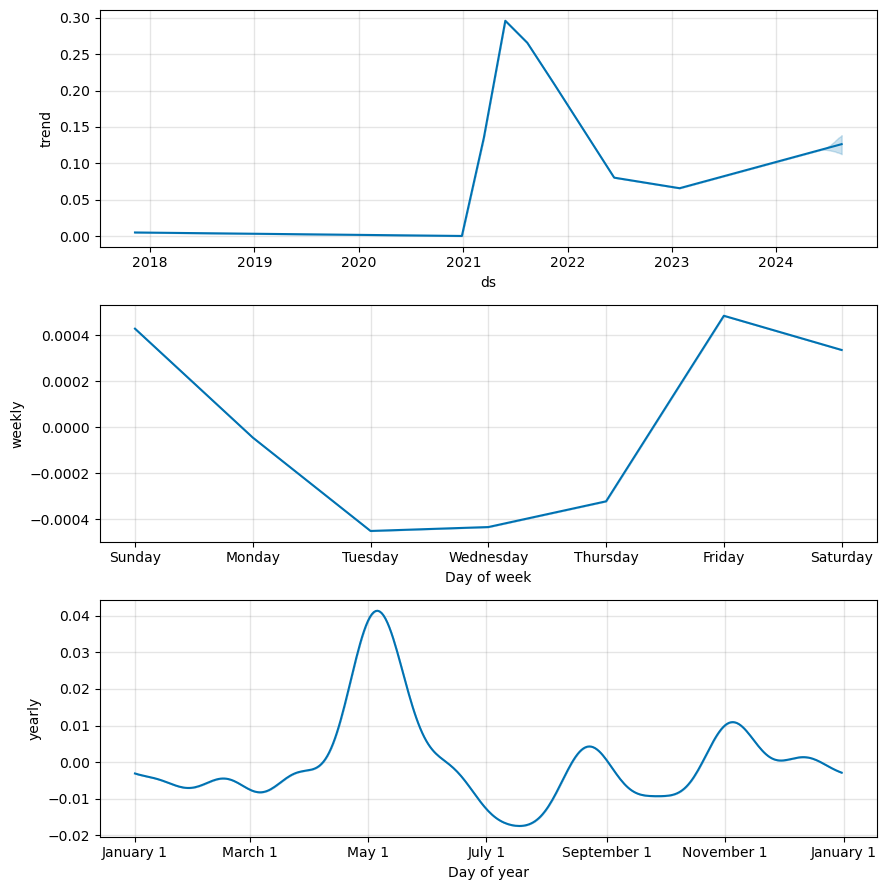

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

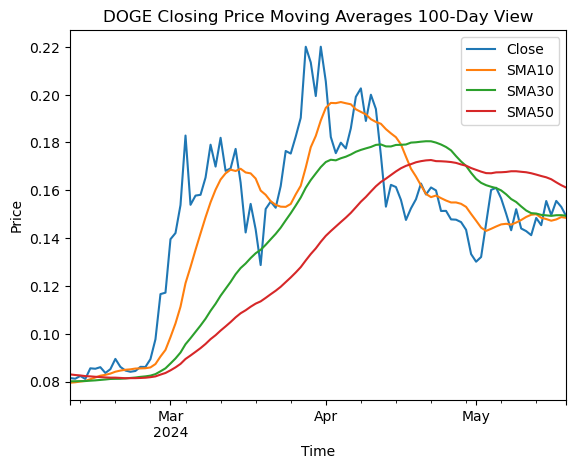

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

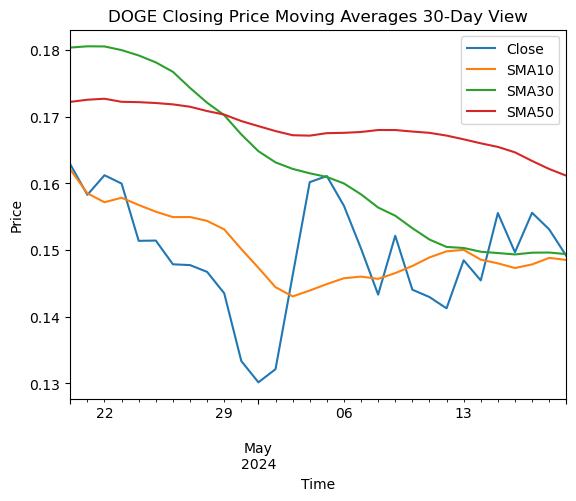

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')  
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747
BNB,574.63,-0.23839504335644301,-0.2336482812093087,-0.1748296149590688
BONK,2.5e-05,0.1887956631518306,0.32592832450639286,0